In [7]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from collections import Counter
import os, sys
from nltk.tokenize import RegexpTokenizer
import numpy as np
import keras


data_path = 'ohsumed-first-20000-docs'
# data_path = 'ohsumed-all'
rep_train = 'training'
rep_test = 'test'



documents_train = {}
documents_test = {}

# words counting
word_counter = Counter()
for y in os.listdir(data_path + '/' + rep_train):
    documents_train[y] = 0
    for fichier in os.listdir(data_path + '/' + rep_train + '/' + y):
        documents_train[y] += 1
        with open(data_path + '/' + rep_train + '/' + y + '/' + fichier) as file:
            article = file.read().lower()
            tokenizer = RegexpTokenizer(r'\w+')
            words = tokenizer.tokenize(article)
            word_counter.update(words)
            
for y in os.listdir(data_path + '/' + rep_test):
    documents_test[y] = 0
    for fichier in os.listdir(data_path + '/' + rep_test + '/' + y):
        documents_test[y] += 1

#### Analyse des données

Taille du vocabulaires, fréquence des mots

In [8]:
print(len(word_counter))

30517


In [9]:
Counter(word_counter).most_common(10)

[('the', 85037),
 ('of', 84510),
 ('and', 57271),
 ('in', 55122),
 ('to', 30870),
 ('with', 30625),
 ('a', 30493),
 ('patients', 22609),
 ('was', 19231),
 ('were', 16884)]

In [39]:
nb_articles_train = 0
for v in documents_train :
    nb_articles_train += documents_train[v]
print(nb_articles_train)

10433


In [40]:
nb_articles_test = 0
for v in documents_test :
    nb_articles_test += documents_test[v]
print(nb_articles_test)

12733


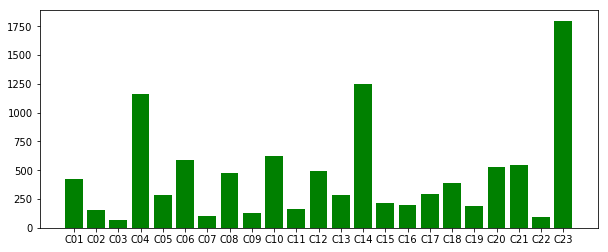

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(10,4))
plt.bar(list(documents_train.keys()), documents_train.values(), color='g')
plt.show()

#### Préprocessing

In [114]:
global_nb_word = 20000
wordlist = [key for key, _ in word_counter.most_common(global_nb_word)]
print(wordlist.index("the"))

0


In [127]:
nb_word = 80

x_train = []
y_train = []
x_test = []
y_test = []

for y in os.listdir(data_path + '/' + rep_train):
    for fichier in os.listdir(data_path + '/' + rep_train + '/' + y):
        with open(data_path + '/' + rep_train + '/' + y + '/' + fichier) as file:
            l = []
            article = file.read().lower()
            tokenizer = RegexpTokenizer(r'\w+')
            words = tokenizer.tokenize(article)
            for word in words:
                    try:
                        index = wordlist.index(word)
                        l.append(index)
                    except ValueError:
                        pass
            x_train.append(l)
            y_train.append(int(y[1:]))
                          
for y in os.listdir(data_path + '/' + rep_test):
    for fichier in os.listdir(data_path + '/' + rep_test + '/' + y):
        with open(data_path + '/' + rep_test + '/' + y + '/' + fichier) as file:
            l = []
            article = file.read().lower()
            tokenizer = RegexpTokenizer(r'\w+')
            words = tokenizer.tokenize(article)
            for word in words:
                    try:
                        index = wordlist.index(word)
                        l.append(index)
                    except ValueError:
                        pass
            x_test.append(l)
            y_test.append(int(y[1:]))


        

In [128]:
x_train= np.array(x_train)
y_train= np.array(y_train)
x_test= np.array(x_test)
y_test= np.array(y_test)
y_train -= 1
y_test -= 1

We have some correct datasets composed of vectors
Now, we will format the datasets by cuting texts after a specific number of word and convert the class vectors to binary class matrices.

In [129]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM
from keras.datasets import imdb


# cut texts after this number of words (among top max_features most common words)
maxlen = 150
batch_size = 128
num_classes = 23

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


Pad sequences (samples x time)
x_train shape: (10433, 150)
x_test shape: (12733, 150)


Then we can create the neural network and train it. Then we will validate our model

In [130]:
model = Sequential()
model.add(Embedding(global_nb_word, 128))
model.add(Dropout(0.35))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(23, activation='relu'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 10433 samples, validate on 12733 samples
Epoch 1/3
10433/10433 [==============================] - 80s 8ms/step - loss: 4.5733 - acc: 0.0801 - val_loss: 3.5676 - val_acc: 0.1476
Epoch 2/3
10433/10433 [==============================] - 82s 8ms/step - loss: 3.1409 - acc: 0.1939 - val_loss: 3.0952 - val_acc: 0.1879
Epoch 3/3
12733/12733 [==============================] - 16s 1ms/step
Test score: 3.182603502698605
Test accuracy: 0.19767533180092564


Le réseau ne semble pas apprendre efficacement. Certaines optimisations sont probablement necessaires si l'on veut des résultats plus convainca